# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2019

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

## Librería usada: OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la documentación oficial de OpenAI.

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee tres métodos principales (info. basada en la documentación oficial de Gym):


    reset(self): Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.
    step(self, action): "Avanza" un timestep del ambiente. Devuelve: observation, reward, done, info.
    render(self): Muestra en pantalla una parte del ambiente.
    close(self): Finaliza con la instancia del agente.
    seed(self): Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

    action_space: El objeto de tipo Space correspondiente al espacio de acciones válidas.
    observation_space: El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.
    reward_range: Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg. Para hacerlo desde Linux ejecutar en consola

	sudo apt-get install ffmpeg

desde Windows descargarla desde

[https://ffmpeg.zeranoe.com/builds/]()

Ejemplo: agente CartPole

In [40]:
import gym
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from agents.utils.plotting import plot_reward_per_episode, plot_steps_per_episode, plot_steps_per_episode_smooth, draw_value_matrix

## Ejemplo 1: The Cliff. 


![](images/cliffwalking.png)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* ^ - Arriba
* v - Abajo
* \> - Derecha
* < - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

# SARSA

In [2]:
def sarsa_choose_action(state, q, epsilon):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [3]:
def sarsa_learn(state, action, reward, next_state, next_action, q, alpha, gamma):
    """
    Performs a SARSA update for a given state transition
    """
    current_q = q.get((state,action), 0.0)
    next_q = q.get((next_state,next_action), 0.0)
    q[(state,action)] = current_q + alpha * (reward + gamma * next_q - current_q)
    

Finalmente, definimos el método principal de iteraciones. 

In [4]:
def sarsa_run(q, alpha, gamma, epsilon, episodes_to_run):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = sarsa_choose_action(state, q, epsilon)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = sarsa_choose_action(next_state, q, epsilon)
            

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                sarsa_learn(state, action, reward, next_state, next_action, q, alpha, gamma)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                sarsa_learn(state, action, reward, next_state, next_action, q, alpha, gamma) 
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

## Variando alpha y gamma

In [5]:
avg_steps_per_episode_sarsa_alpha= {}
timesteps_ep_sarsa_alpha = {}
reward_ep_sarsa_alpha = {} 


for alpha in [ 0.4, 0.5, 0.75, 1.0]:
    for gamma in [0.0, 0.25, 0.5, 0.75, 1.0]:
        q_sarsa_i = {}

        # definimos sus híper-parámetros básicos

        alpha_sarsa_i = alpha
        gamma_sarsa_i = gamma
        epsilon_sarsa_i = 0.1
        tau_sarsa_i = 25

        episodes_to_run_sarsa_i = 500

        env = gym.make("CliffWalking-v0")
        actions = range(env.action_space.n)

        # se declara una semilla aleatoria
        random_state = np.random.RandomState(42)
        avg_steps_per_episode_sarsa_i, timesteps_ep_sarsa_i, reward_ep_sarsa_i = sarsa_run(q_sarsa_i, alpha_sarsa_i, gamma_sarsa_i, epsilon_sarsa_i, episodes_to_run_sarsa_i)
        env.close()
        avg_steps_per_episode_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = avg_steps_per_episode_sarsa_i
        timesteps_ep_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = timesteps_ep_sarsa_i
        reward_ep_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)]  =  reward_ep_sarsa_i


Text(0.5, 0, 'Episodio')

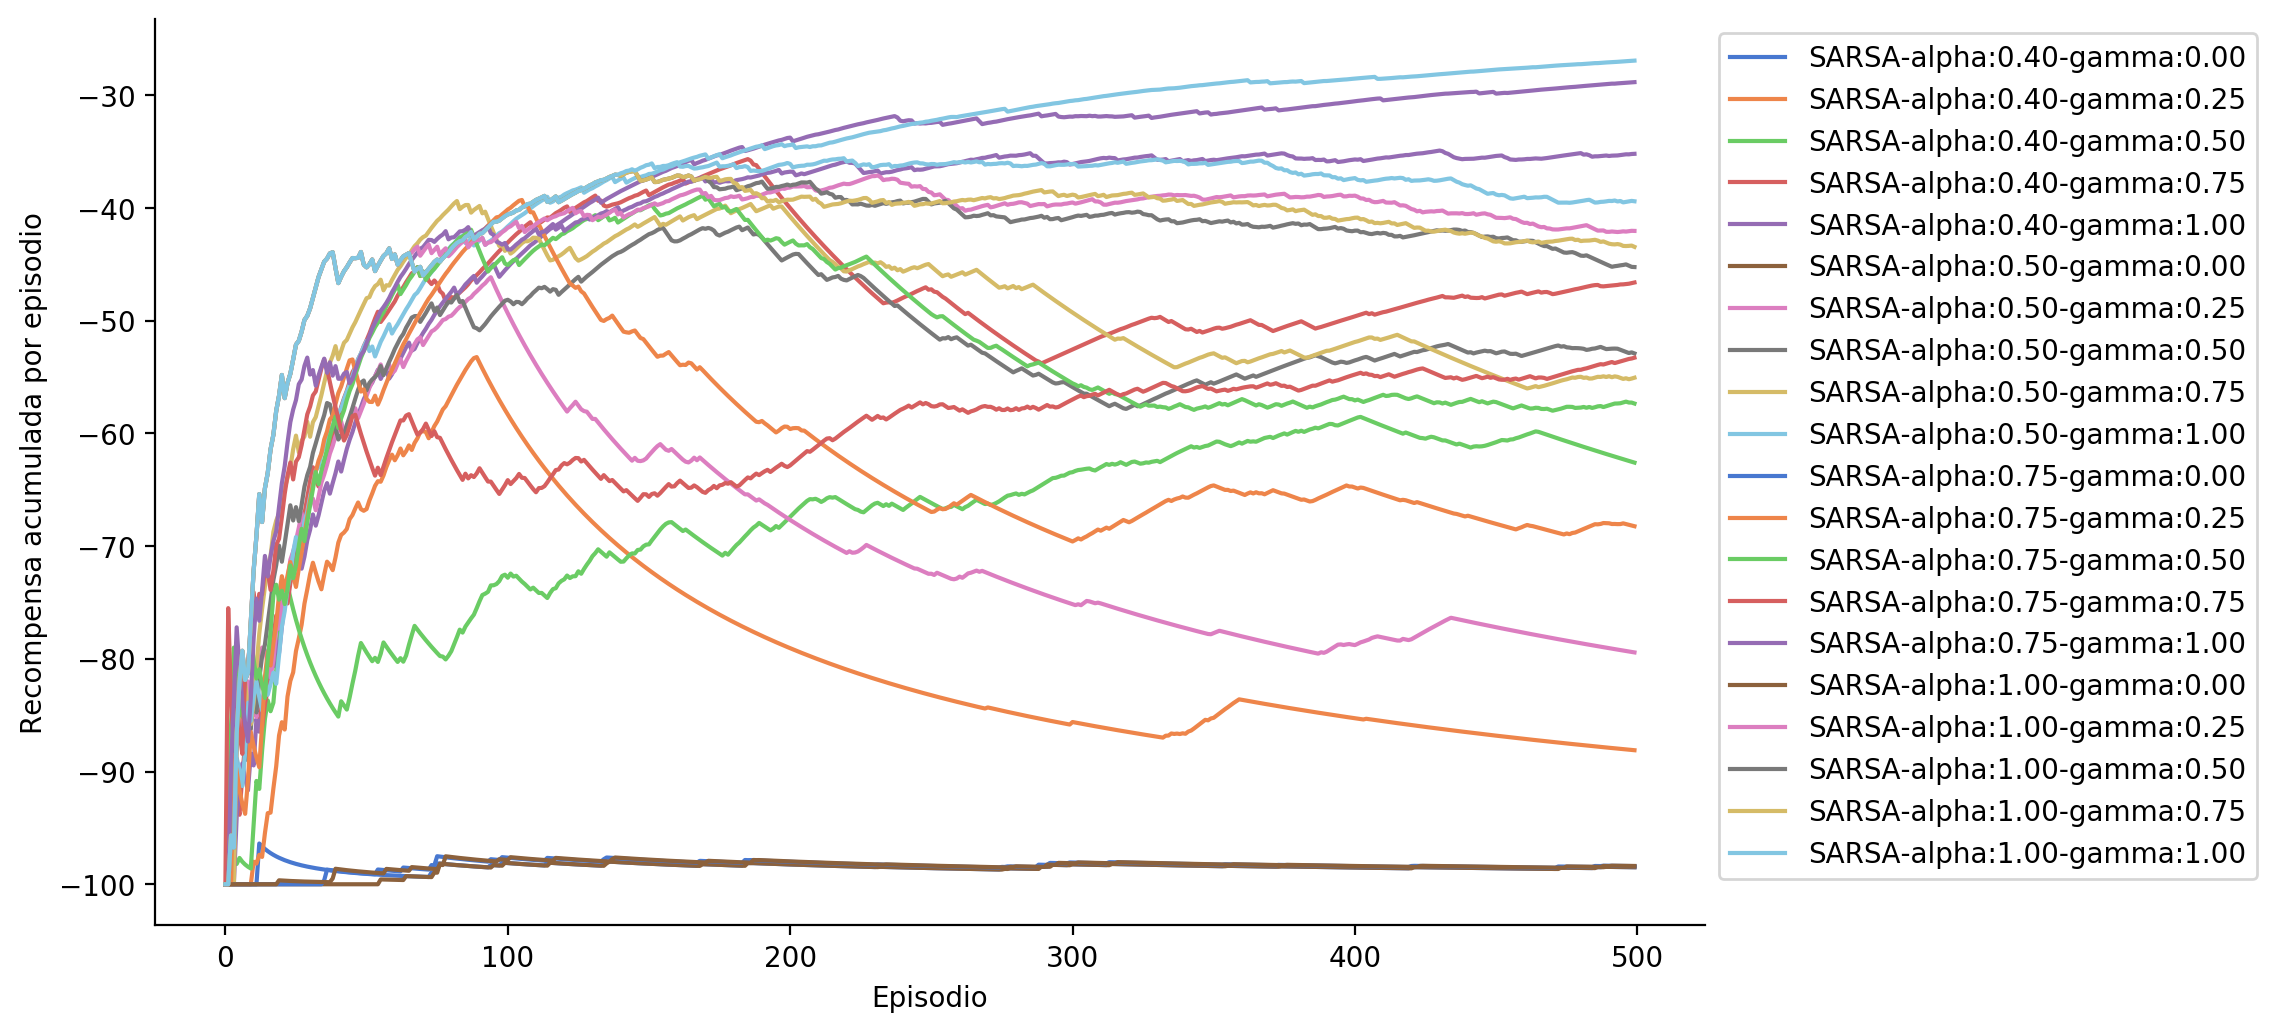

In [6]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(reward_ep_sarsa_alpha)
sns.lineplot(data=df.rolling(500,min_periods=1).mean(),dashes=False, palette=sns.color_palette("muted",20))
sns.despine()
plt.legend(bbox_to_anchor=(1.0, 1))
plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")


## Variando el alpha

In [7]:
avg_steps_per_episode_sarsa_alpha= {}
timesteps_ep_sarsa_alpha = {}
reward_ep_sarsa_alpha = {} 


for alpha in [ 0.4, 0.5, 0.75, 1.0]:
    for gamma in [1.0]:
        q_sarsa_i = {}

        # definimos sus híper-parámetros básicos

        alpha_sarsa_i = alpha
        gamma_sarsa_i = gamma
        epsilon_sarsa_i = 0.1
        tau_sarsa_i = 25

        episodes_to_run_sarsa_i = 500

        env = gym.make("CliffWalking-v0")
        actions = range(env.action_space.n)

        # se declara una semilla aleatoria
        random_state = np.random.RandomState(42)
        avg_steps_per_episode_sarsa_i, timesteps_ep_sarsa_i, reward_ep_sarsa_i = sarsa_run(q_sarsa_i, alpha_sarsa_i, gamma_sarsa_i, epsilon_sarsa_i, episodes_to_run_sarsa_i)
        env.close()
        avg_steps_per_episode_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = avg_steps_per_episode_sarsa_i
        timesteps_ep_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = timesteps_ep_sarsa_i
        reward_ep_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)]  =  reward_ep_sarsa_i


Text(0.5, 0, 'Episodio')

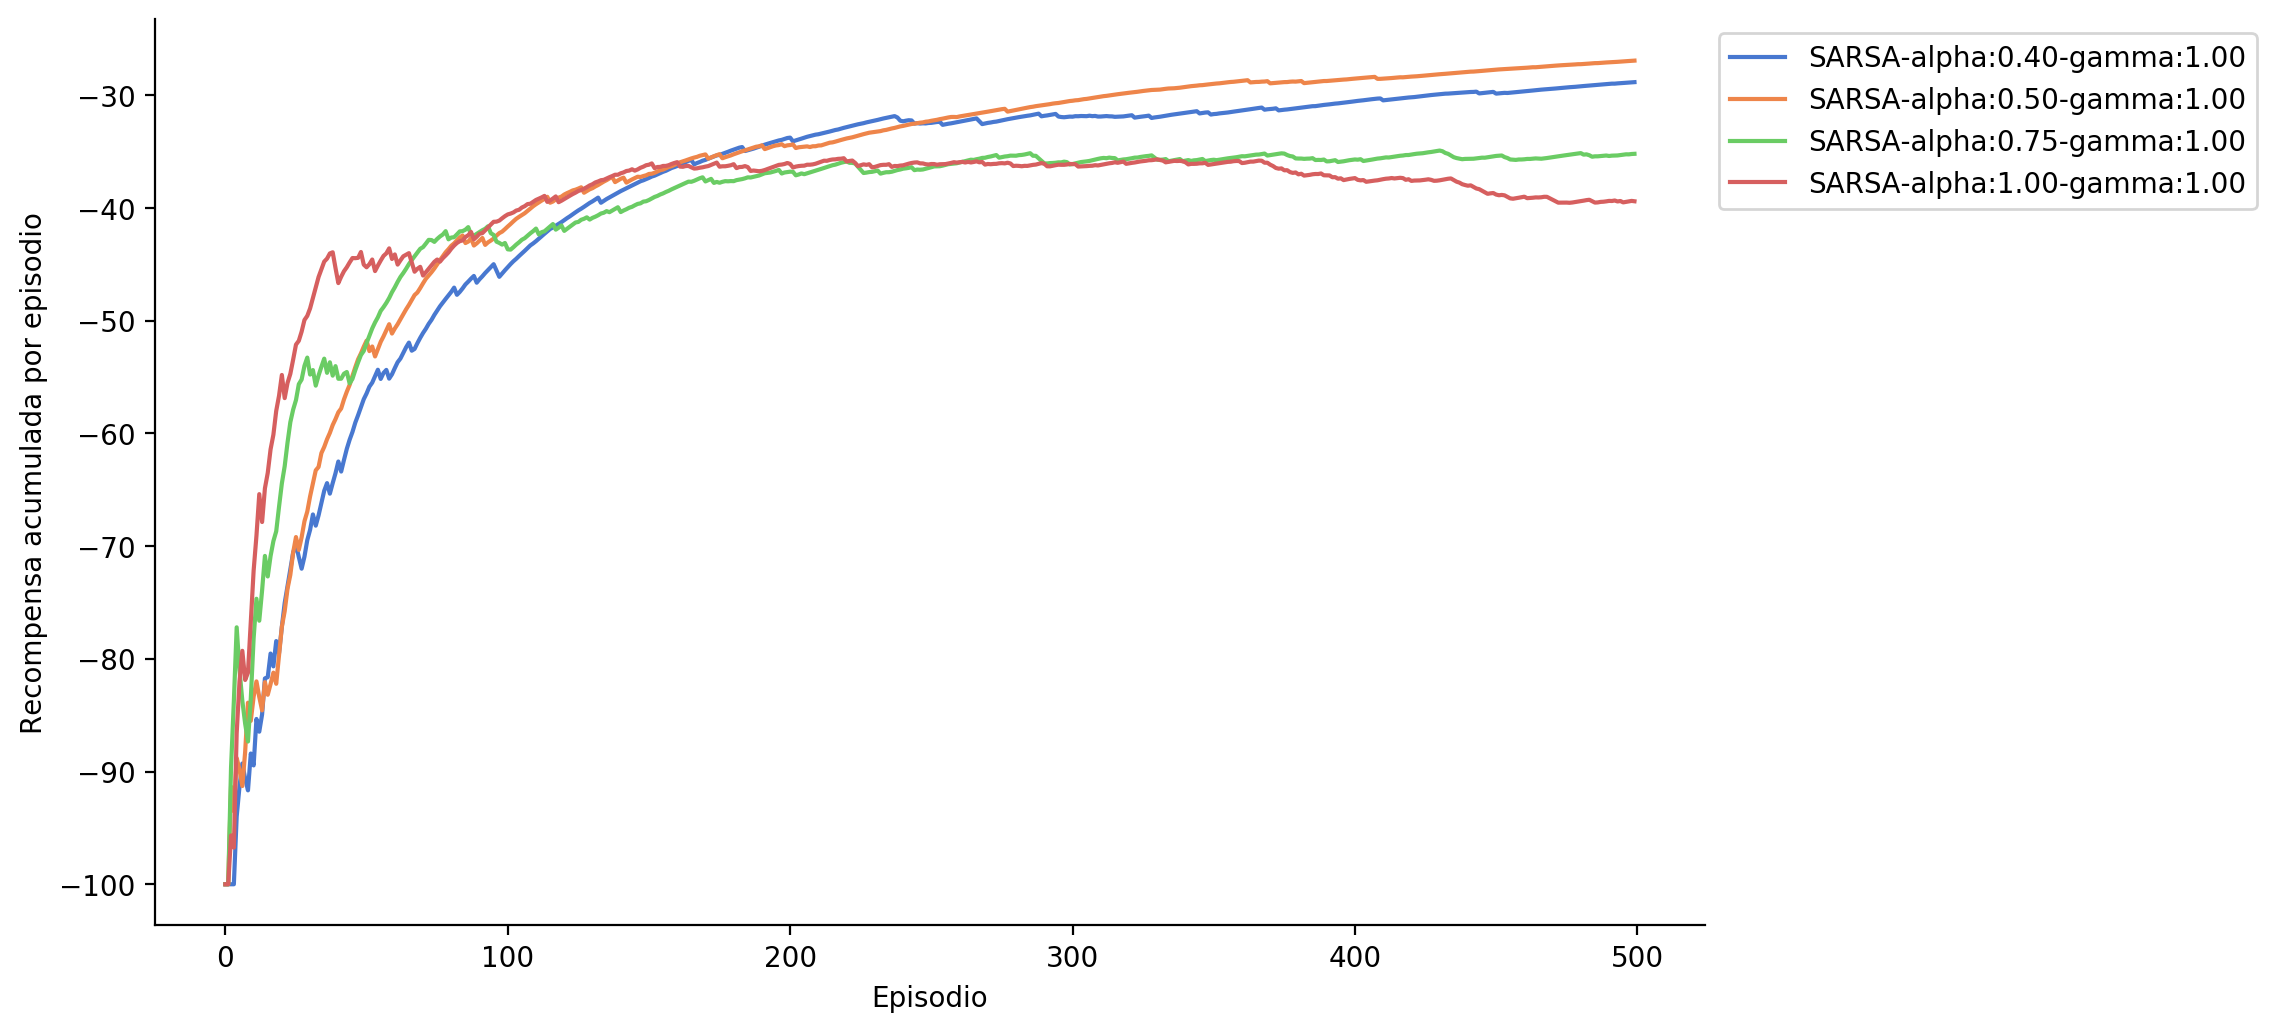

In [8]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(reward_ep_sarsa_alpha)
sns.lineplot(data=df.rolling(500,min_periods=1).mean(),dashes=False, palette=sns.color_palette("muted",4))
sns.despine()
plt.legend(bbox_to_anchor=(1.0, 1))
plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")


## Variando el gamma con alpha=0.5

In [9]:
avg_steps_per_episode_sarsa_alpha= {}
timesteps_ep_sarsa_alpha = {}
reward_ep_sarsa_alpha = {} 


for alpha in [0.5]:
    for gamma in [0.0, 0.25, 0.5, 0.75, 1.0]:
        q_sarsa_i = {}

        # definimos sus híper-parámetros básicos

        alpha_sarsa_i = alpha
        gamma_sarsa_i = gamma
        epsilon_sarsa_i = 0.1
        tau_sarsa_i = 25

        episodes_to_run_sarsa_i = 500

        env = gym.make("CliffWalking-v0")
        actions = range(env.action_space.n)

        # se declara una semilla aleatoria
        random_state = np.random.RandomState(42)
        avg_steps_per_episode_sarsa_i, timesteps_ep_sarsa_i, reward_ep_sarsa_i = sarsa_run(q_sarsa_i, alpha_sarsa_i, gamma_sarsa_i, epsilon_sarsa_i, episodes_to_run_sarsa_i)
        env.close()
        avg_steps_per_episode_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = avg_steps_per_episode_sarsa_i
        timesteps_ep_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = timesteps_ep_sarsa_i
        reward_ep_sarsa_alpha["SARSA-alpha:%.2f-gamma:%.2f"%(alpha,gamma)]  =  reward_ep_sarsa_i


Text(0.5, 0, 'Episodio')

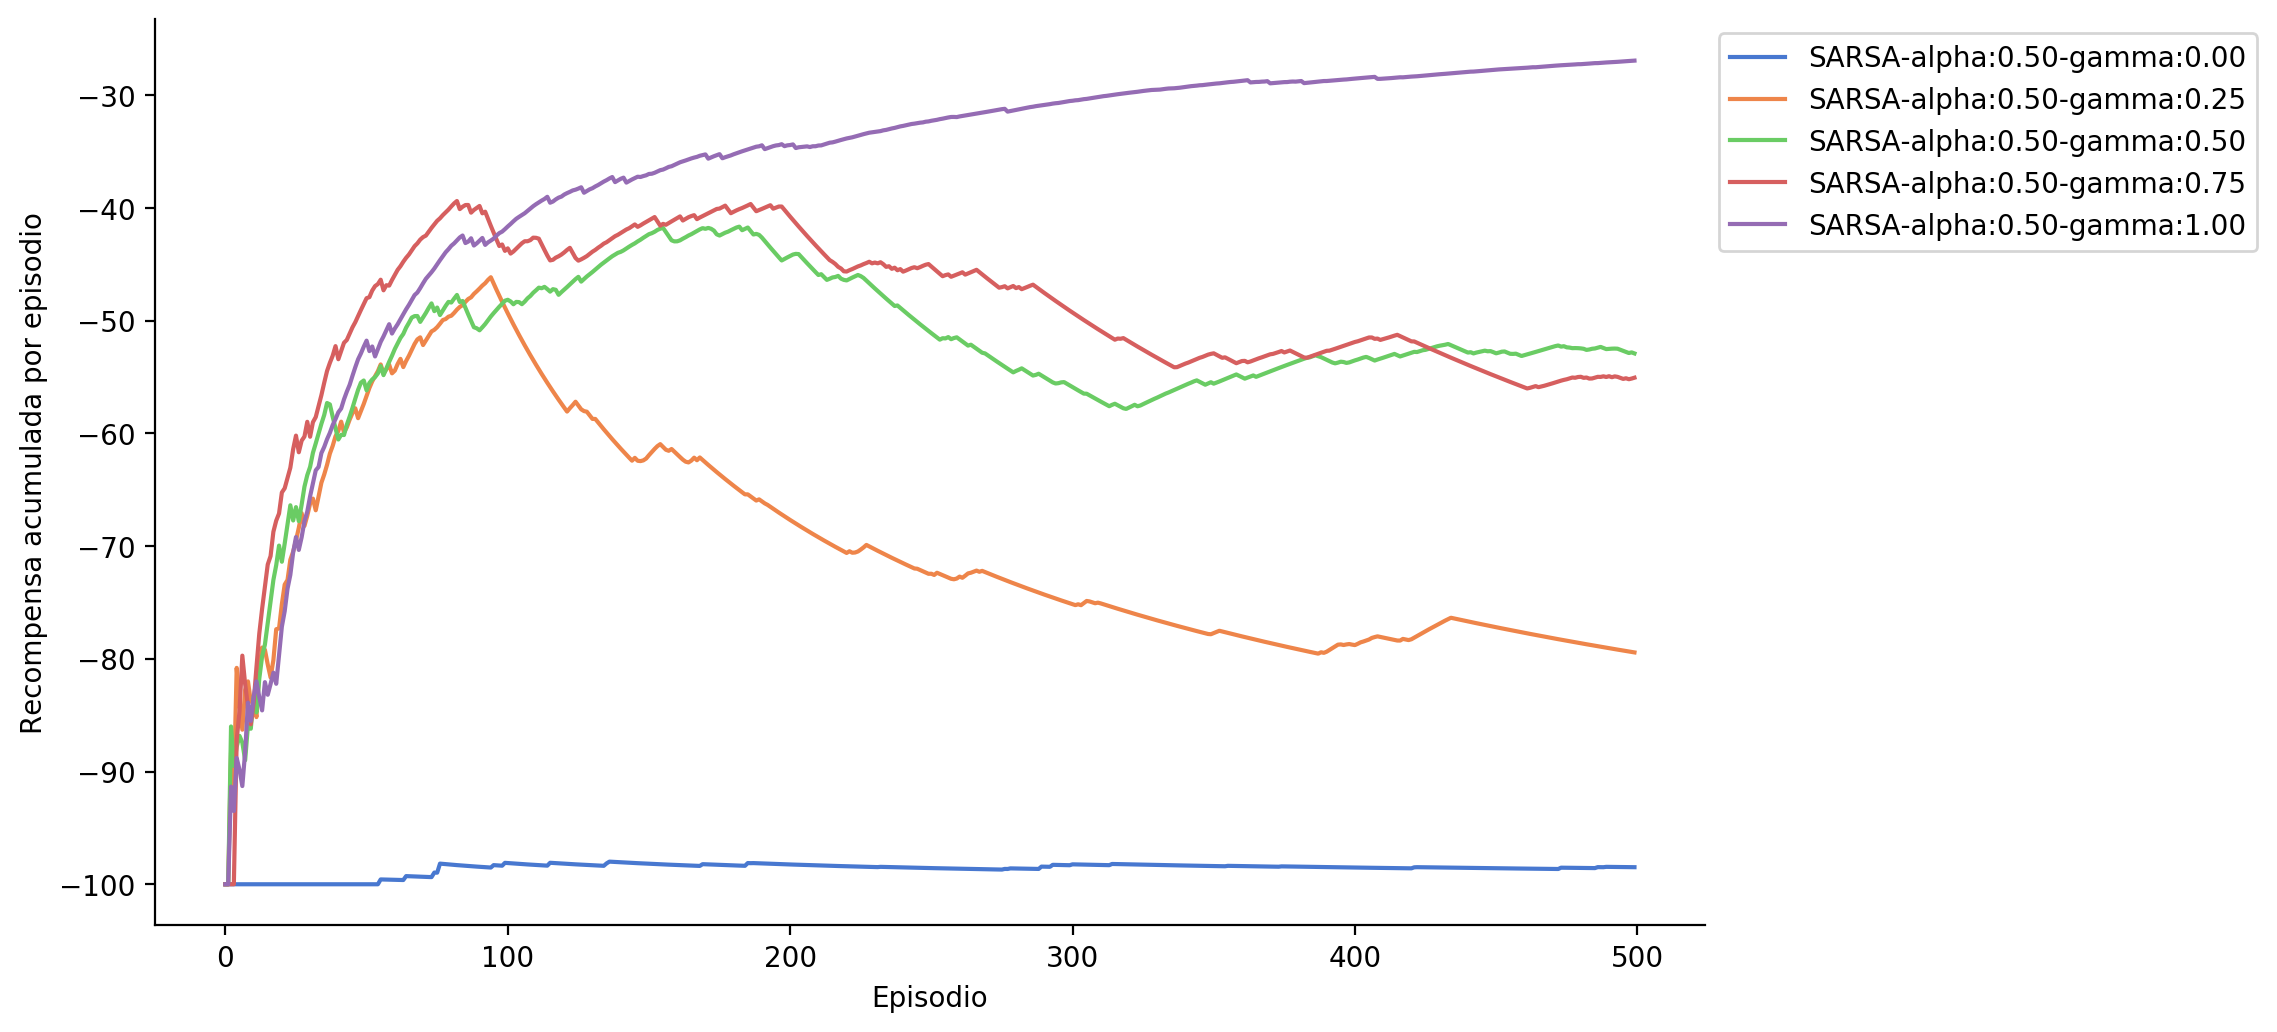

In [10]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(reward_ep_sarsa_alpha)
sns.lineplot(data=df.rolling(500,min_periods=1).mean(),dashes=False, palette=sns.color_palette("muted",5))
sns.despine()
plt.legend(bbox_to_anchor=(1.0, 1))
plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")



## mejores hiperparámetros para SARSA

- alpha = 0.5
- gamma = 1.0

# Q-learning

In [11]:
def choose_action_qlearning(state, q, epsilon):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:
        return random_state.choice(actions)  # a random action is selected

    count = q_values.count(max_q)

    # In case there're several state-action max values
    # we select a random one among them
    if count > 1:
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [12]:
def learn_qlearning(state, action, reward, next_state, q, alpha, gamma):
    """
    Performs a SARSA update for a given state transition
    """
    current_q = q.get((state,action), 0.0)
    
    q_values = [q.get((next_state, a), 0.0) for a in actions]
    max_q = max(q_values)   
    
    q[(state,action)] = current_q + alpha * (reward + gamma * max_q - current_q)
    

Finalmente, definimos el método principal de iteraciones. 

In [13]:
def run_qlearning(q, alpha, gamma, epsilon, episodes_to_run):
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        
        
        while not done:
            action = choose_action_qlearning(state, q, epsilon)
            next_state, reward, done, info = env.step(action)         

            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learn_qlearning(state, action, reward, next_state, q, alpha, gamma)
                state = next_state
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learn_qlearning(state, action, reward, next_state, q, alpha, gamma)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

## Variando alpha y gamma

In [15]:
avg_steps_per_episode_qlearning_alpha= {}
timesteps_ep_qlearning_alpha = {}
reward_ep_qlearning_alpha = {} 


for alpha in [ 0.5, 0.75, 1.0]:
    for gamma in [0.0, 0.25, 0.5, 0.75, 1.0]:
        q_qlearning_i = {}

        # definimos sus híper-parámetros básicos

        alpha_qlearning_i = alpha
        gamma_qlearning_i = gamma
        epsilon_qlearning_i = 0.1
        tau_qlearning_i = 25

        episodes_to_run_qlearning_i = 500

        env = gym.make("CliffWalking-v0")
        actions = range(env.action_space.n)

        # se declara una semilla aleatoria
        random_state = np.random.RandomState(42)
        avg_steps_per_episode_qlearning_i, timesteps_ep_qlearning_i, reward_ep_qlearning_i = run_qlearning(q_qlearning_i, alpha_qlearning_i, gamma_qlearning_i, epsilon_qlearning_i, episodes_to_run_qlearning_i)
        env.close()
        avg_steps_per_episode_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = avg_steps_per_episode_qlearning_i
        timesteps_ep_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = timesteps_ep_qlearning_i
        reward_ep_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)]  =  reward_ep_qlearning_i


Text(0.5, 0, 'Episodio')

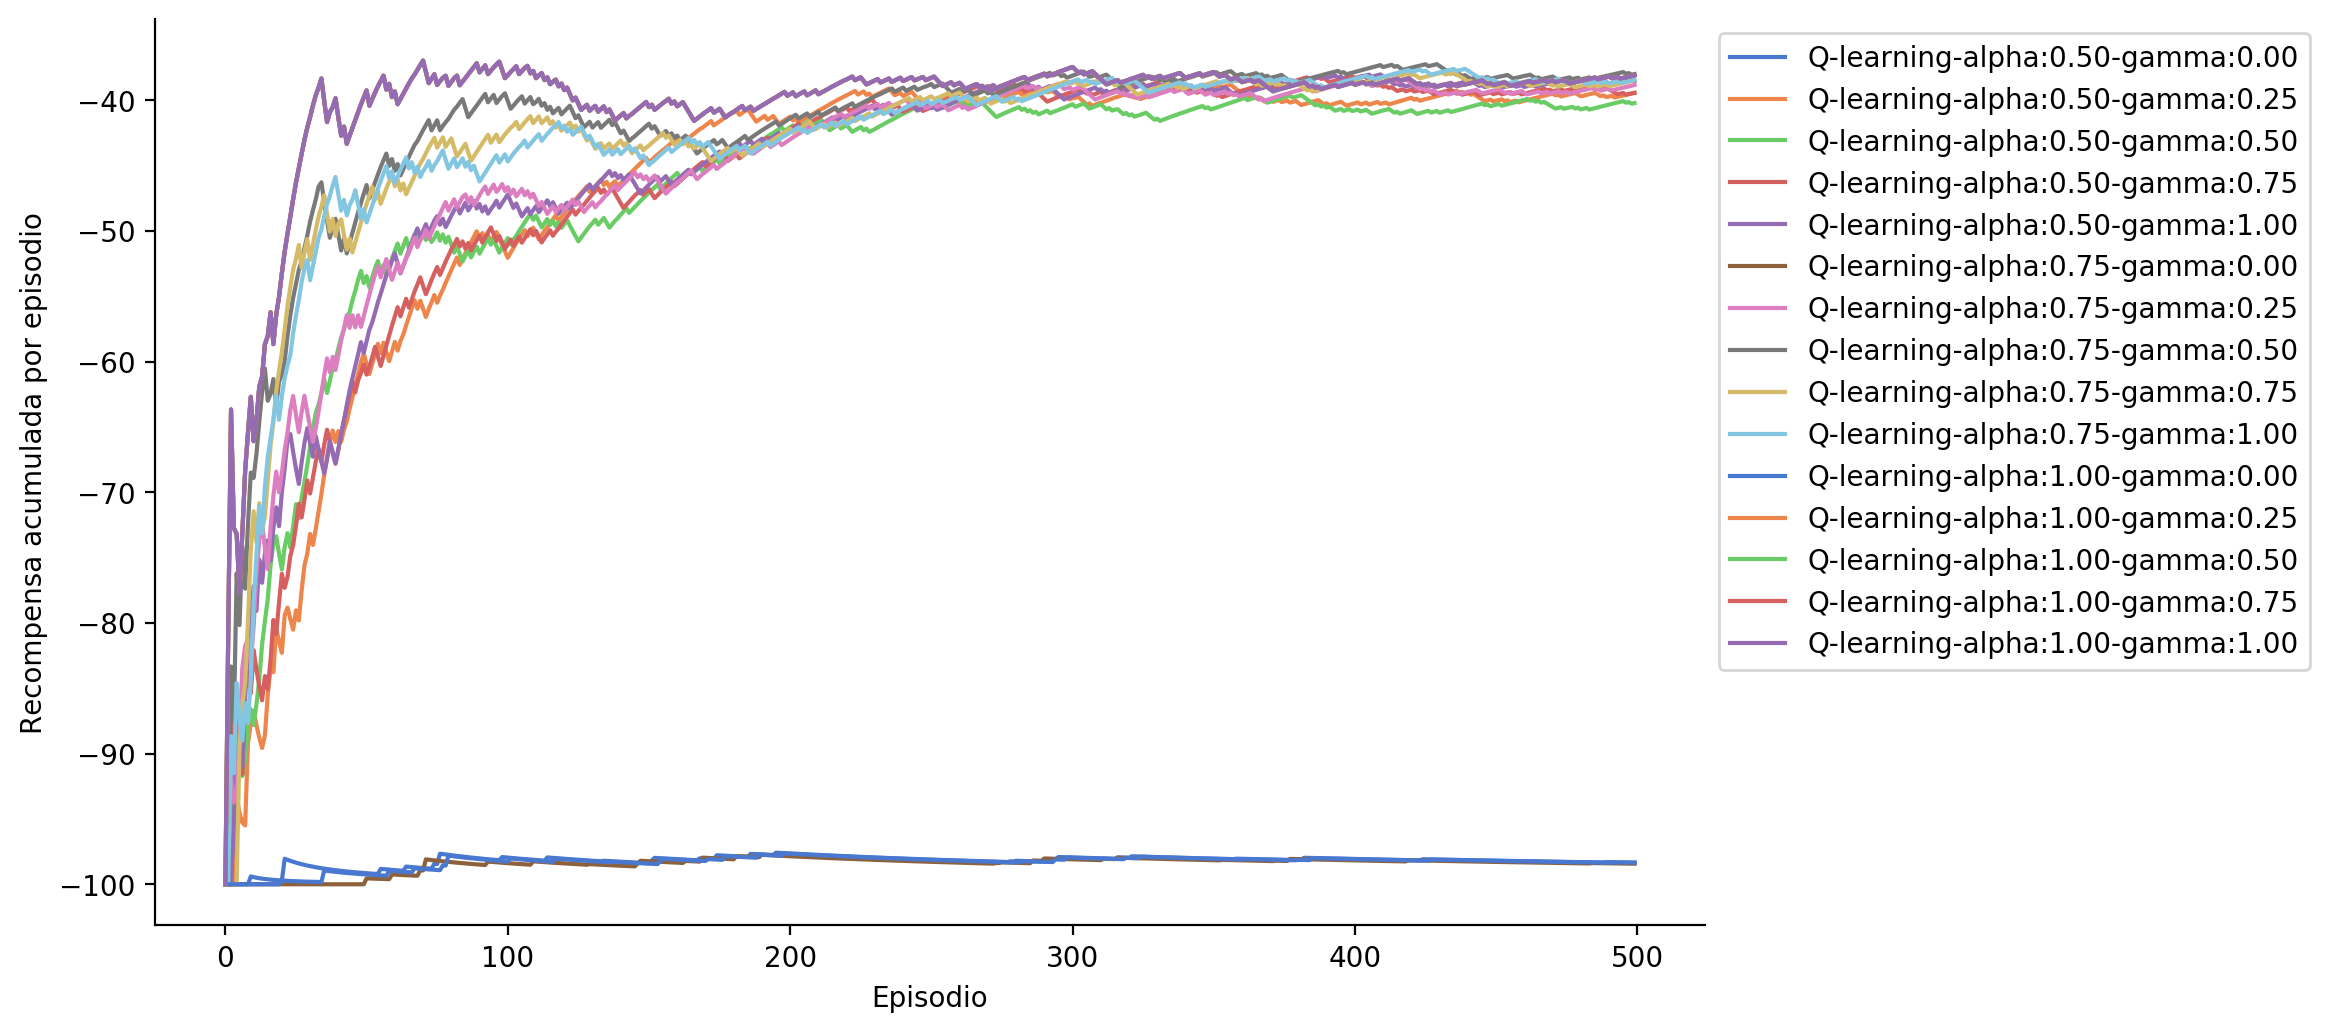

In [17]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(reward_ep_qlearning_alpha)
sns.lineplot(data=df.rolling(500,min_periods=1).mean(),dashes=False, palette=sns.color_palette("muted",15))
sns.despine()
plt.legend(bbox_to_anchor=(1.0, 1))
plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")


## Variando alpha y gamma=1.0

In [18]:
avg_steps_per_episode_qlearning_alpha= {}
timesteps_ep_qlearning_alpha = {}
reward_ep_qlearning_alpha = {} 


for alpha in [0.0, 0.25, 0.5, 0.75, 1.0]:
    for gamma in [1.0]:
        q_qlearning_i = {}

        # definimos sus híper-parámetros básicos

        alpha_qlearning_i = alpha
        gamma_qlearning_i = gamma
        epsilon_qlearning_i = 0.1
        tau_qlearning_i = 25

        episodes_to_run_qlearning_i = 500

        env = gym.make("CliffWalking-v0")
        actions = range(env.action_space.n)

        # se declara una semilla aleatoria
        random_state = np.random.RandomState(42)
        avg_steps_per_episode_qlearning_i, timesteps_ep_qlearning_i, reward_ep_qlearning_i = run_qlearning(q_qlearning_i, alpha_qlearning_i, gamma_qlearning_i, epsilon_qlearning_i, episodes_to_run_qlearning_i)
        env.close()
        avg_steps_per_episode_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = avg_steps_per_episode_qlearning_i
        timesteps_ep_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = timesteps_ep_qlearning_i
        reward_ep_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)]  =  reward_ep_qlearning_i


Text(0.5, 0, 'Episodio')

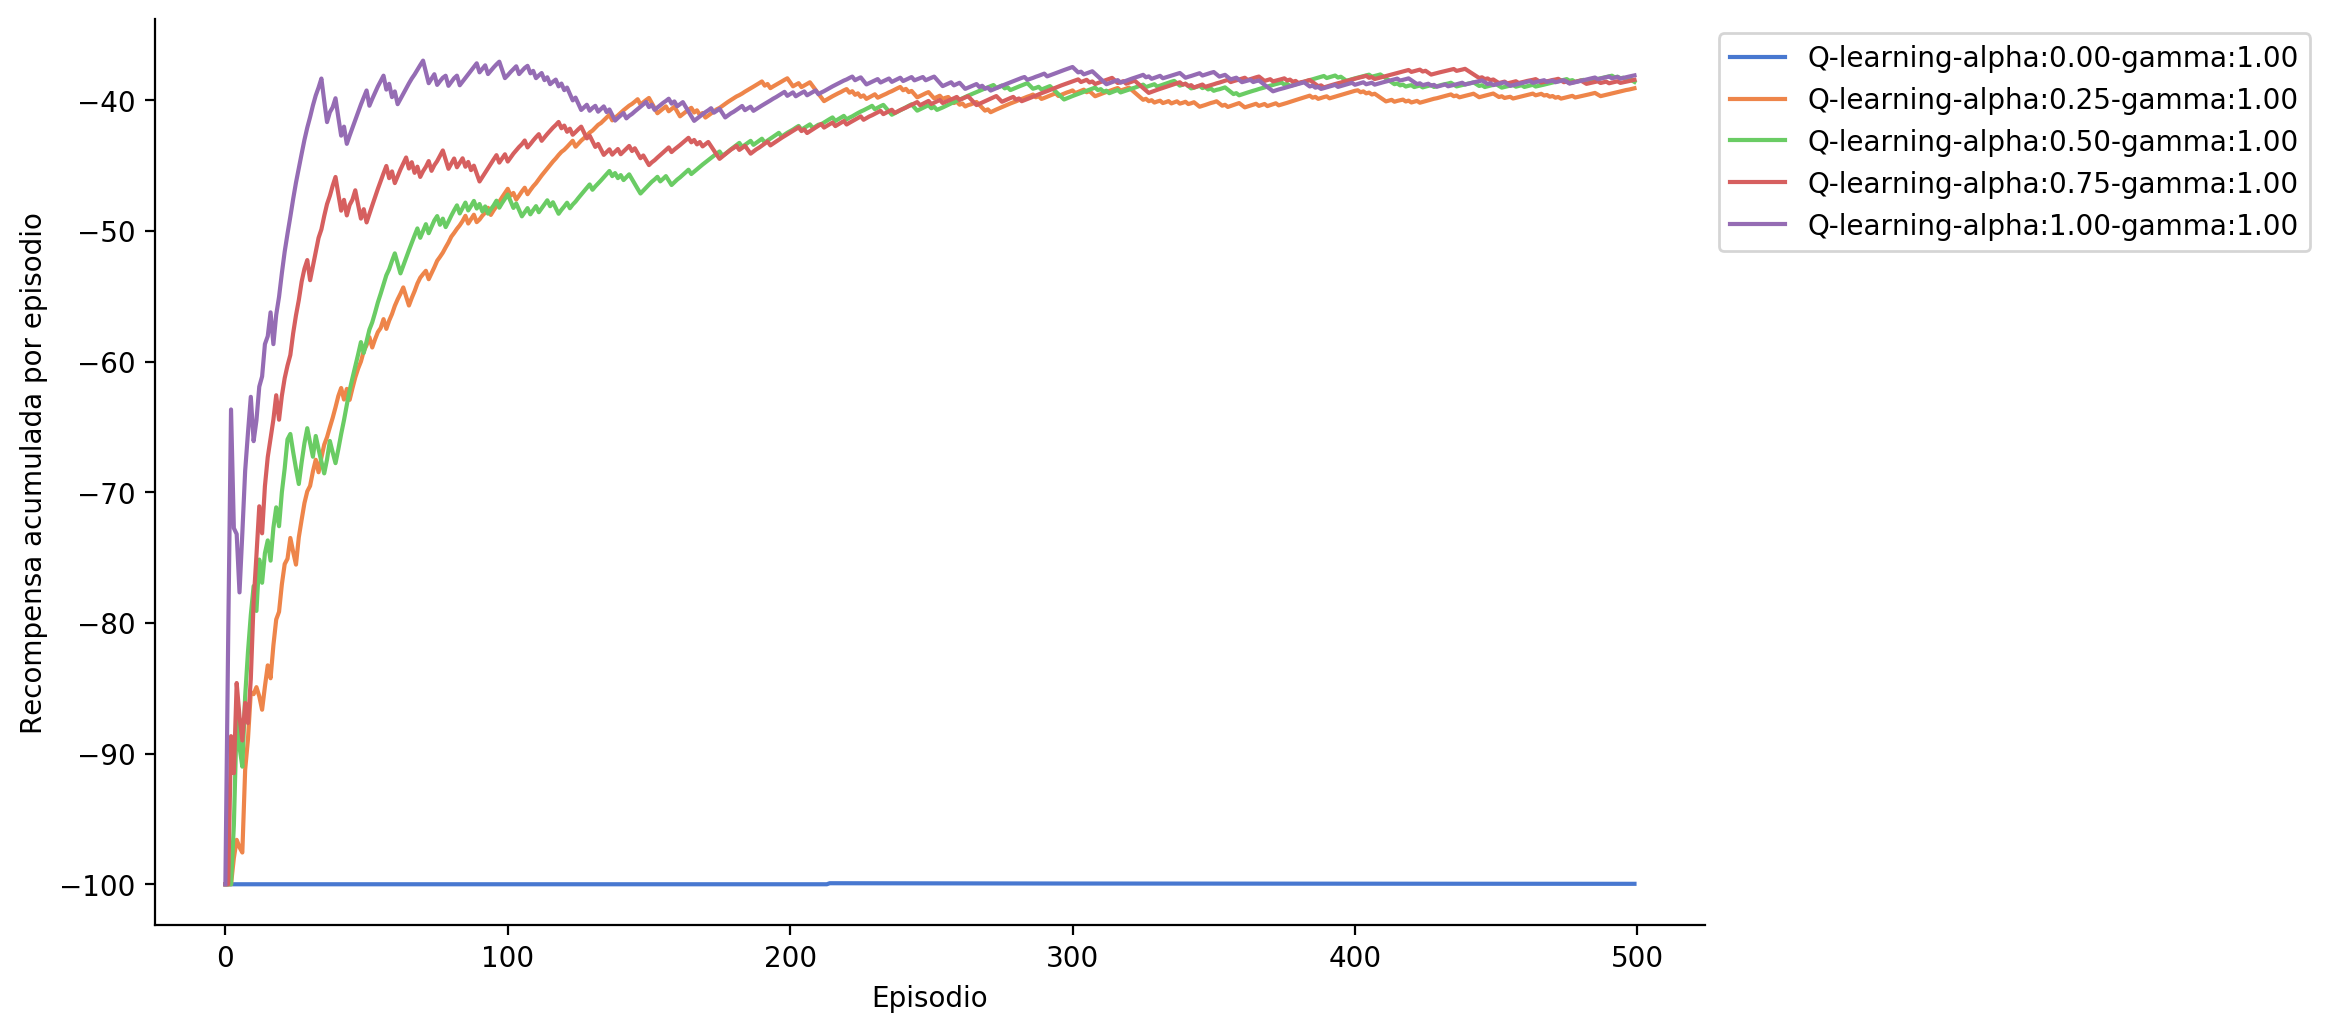

In [19]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(reward_ep_qlearning_alpha)
sns.lineplot(data=df.rolling(500,min_periods=1).mean(),dashes=False, palette=sns.color_palette("muted",5))
sns.despine()
plt.legend(bbox_to_anchor=(1.0, 1))
plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")


## Variando gamma y alpha=0.5

In [20]:
avg_steps_per_episode_qlearning_alpha= {}
timesteps_ep_qlearning_alpha = {}
reward_ep_qlearning_alpha = {} 


for alpha in [0.5]:
    for gamma in [0.0, 0.25, 0.5, 0.75, 1.0] :
        q_qlearning_i = {}

        # definimos sus híper-parámetros básicos

        alpha_qlearning_i = alpha
        gamma_qlearning_i = gamma
        epsilon_qlearning_i = 0.1
        tau_qlearning_i = 25

        episodes_to_run_qlearning_i = 500

        env = gym.make("CliffWalking-v0")
        actions = range(env.action_space.n)

        # se declara una semilla aleatoria
        random_state = np.random.RandomState(42)
        avg_steps_per_episode_qlearning_i, timesteps_ep_qlearning_i, reward_ep_qlearning_i = run_qlearning(q_qlearning_i, alpha_qlearning_i, gamma_qlearning_i, epsilon_qlearning_i, episodes_to_run_qlearning_i)
        env.close()
        avg_steps_per_episode_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = avg_steps_per_episode_qlearning_i
        timesteps_ep_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)] = timesteps_ep_qlearning_i
        reward_ep_qlearning_alpha["Q-learning-alpha:%.2f-gamma:%.2f"%(alpha,gamma)]  =  reward_ep_qlearning_i


Text(0.5, 0, 'Episodio')

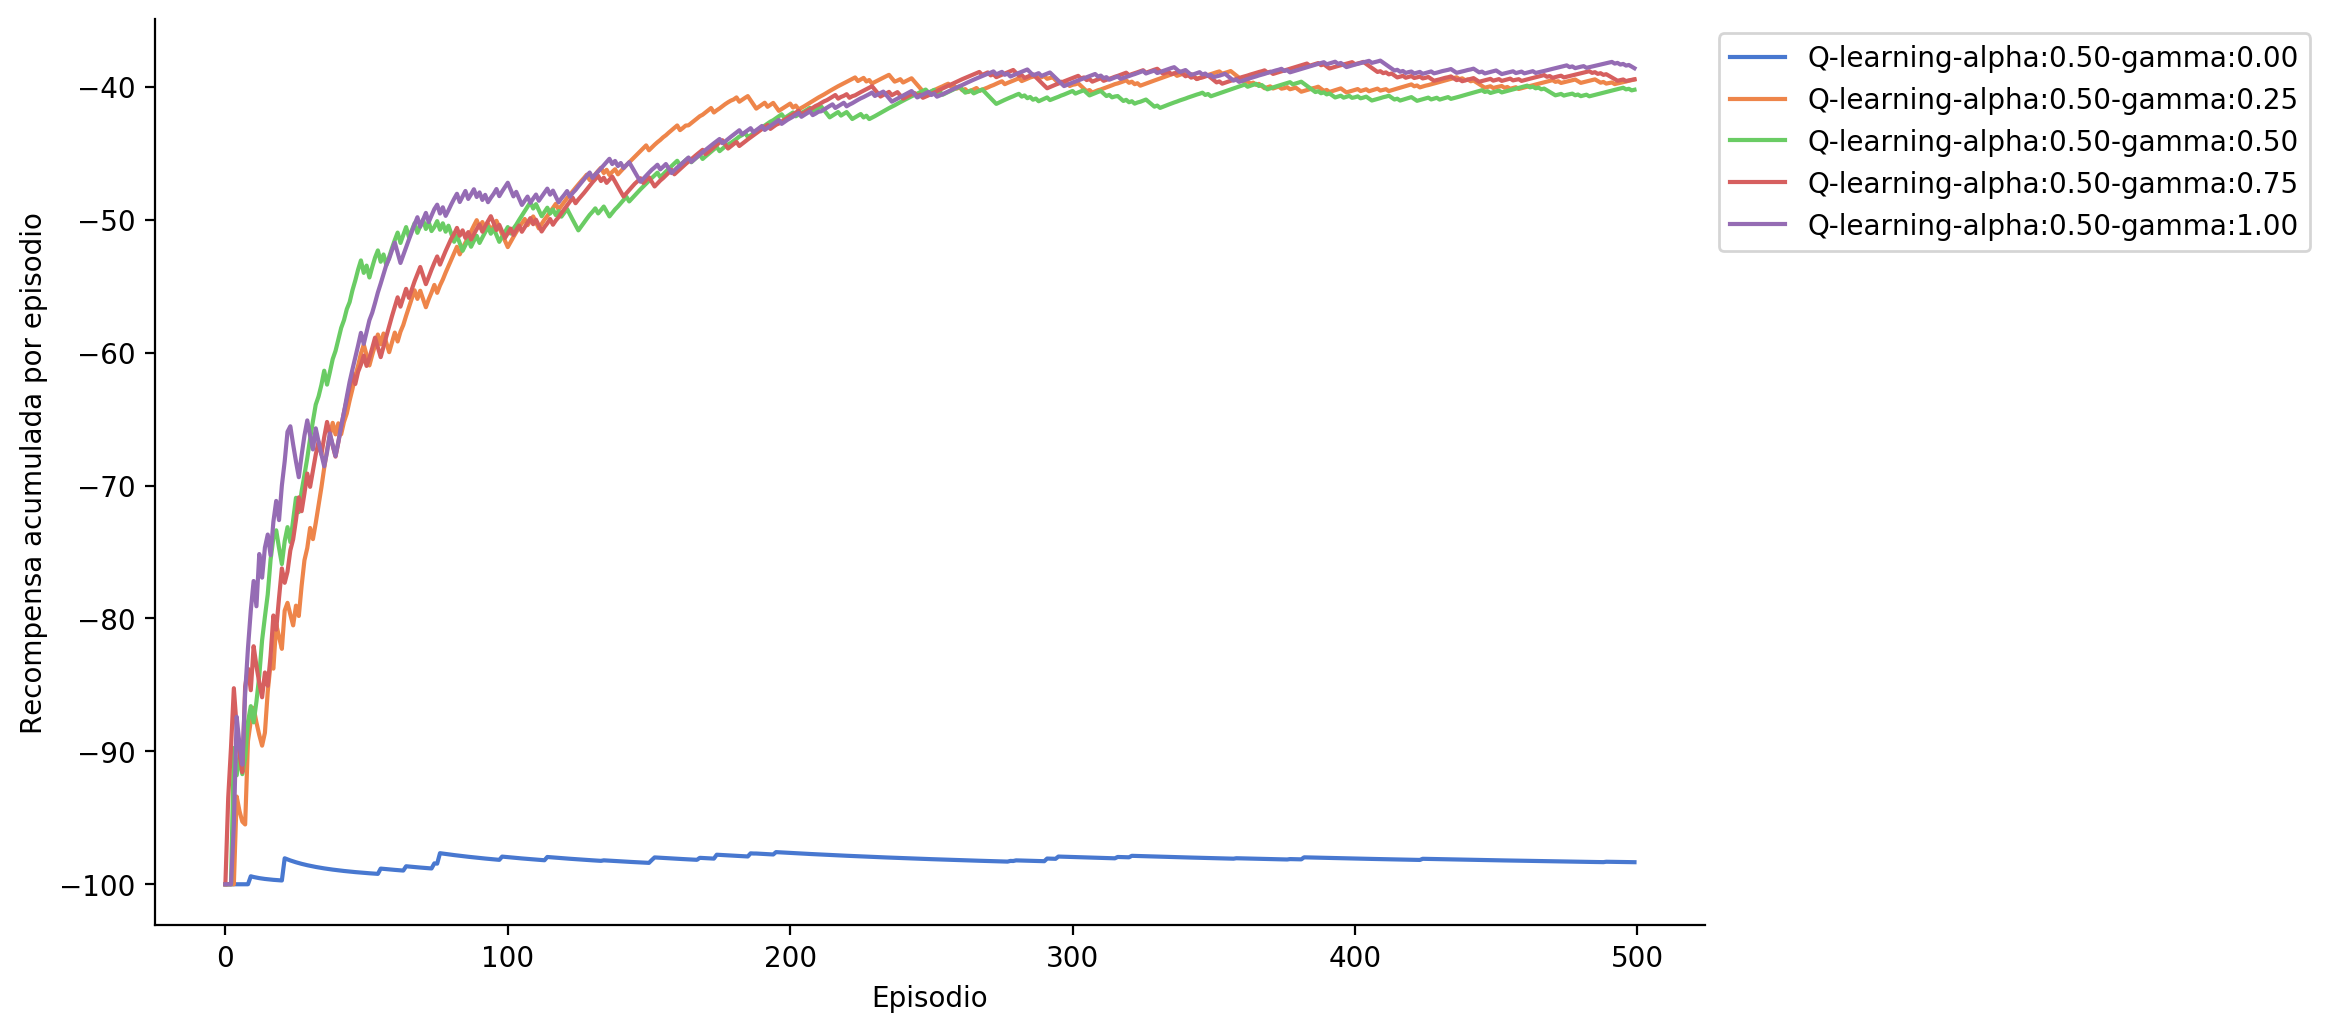

In [21]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(reward_ep_qlearning_alpha)
sns.lineplot(data=df.rolling(500,min_periods=1).mean(),dashes=False, palette=sns.color_palette("muted",5))
sns.despine()
plt.legend(bbox_to_anchor=(1.0, 1))
plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")


## Mejores hiperparámetros de Q-learning

- alpha=0.5
- gamma=1.0

# Comparación

In [32]:
alpha = 0.5
gamma = 1.0

In [45]:
avg_steps_per_episode_alpha= {}
timesteps_ep_alpha = {}
reward_ep_alpha = {} 
q = {}

for epsilon in [0.0, 0.05, 0.1]:
    q_qlearning_i = {}

    # definimos sus híper-parámetros básicos

    alpha_qlearning_i = alpha
    gamma_qlearning_i = gamma
    epsilon_qlearning_i = epsilon
    tau_qlearning_i = 25

    episodes_to_run_qlearning_i = 500

    env = gym.make("CliffWalking-v0")
    actions = range(env.action_space.n)

    # se declara una semilla aleatoria
    random_state = np.random.RandomState(412)
    avg_steps_per_episode_qlearning_i, timesteps_ep_qlearning_i, reward_ep_qlearning_i = run_qlearning(q_qlearning_i, alpha_qlearning_i, gamma_qlearning_i, epsilon_qlearning_i, episodes_to_run_qlearning_i)
    env.close()
    avg_steps_per_episode_alpha["Q-learning-alpha:%.2f-gamma:%.2f-epsilon:%.2f"%(alpha,gamma,epsilon)] = avg_steps_per_episode_qlearning_i
    timesteps_ep_alpha["Q-learning-alpha:%.2f-gamma:%.2f-epsilon:%.2f"%(alpha,gamma,epsilon)] = timesteps_ep_qlearning_i
    reward_ep_alpha["Q-learning-alpha:%.2f-gamma:%.2f-epsilon:%.2f"%(alpha,gamma,epsilon)]  =  reward_ep_qlearning_i
    q["Q-learning-alpha:%.2f-gamma:%.2f-epsilon:%.2f"%(alpha,gamma,epsilon)] = q_qlearning_i
    q_sarsa_i = {}

    # definimos sus híper-parámetros básicos

    alpha_sarsa_i = alpha
    gamma_sarsa_i = gamma
    epsilon_sarsa_i = epsilon
    tau_sarsa_i = 25

    episodes_to_run_sarsa_i = 500

    env = gym.make("CliffWalking-v0")
    actions = range(env.action_space.n)

    # se declara una semilla aleatoria
    random_state = np.random.RandomState(412)
    avg_steps_per_episode_sarsa_i, timesteps_ep_sarsa_i, reward_ep_sarsa_i = sarsa_run(q_sarsa_i, alpha_sarsa_i, gamma_sarsa_i, epsilon_sarsa_i, episodes_to_run_sarsa_i)
    env.close()
    avg_steps_per_episode_alpha["SARSA-alpha:%.2f-gamma:%.2f-epsilon:%.2f"%(alpha,gamma,epsilon)] = avg_steps_per_episode_sarsa_i
    timesteps_ep_alpha["SARSA-alpha:%.2f-gamma:%.2f-epsilon:%.2f"%(alpha,gamma,epsilon)] = timesteps_ep_sarsa_i
    reward_ep_alpha["SARSA-alpha:%.2f-gamma:%.2f-epsilon:%.2f"%(alpha,gamma,epsilon)]  =  reward_ep_sarsa_i
    q["SARSA-alpha:%.2f-gamma:%.2f-epsilon:%.2f"%(alpha,gamma,epsilon)] = q_sarsa_i
    

Text(0.5, 0, 'Episodio')

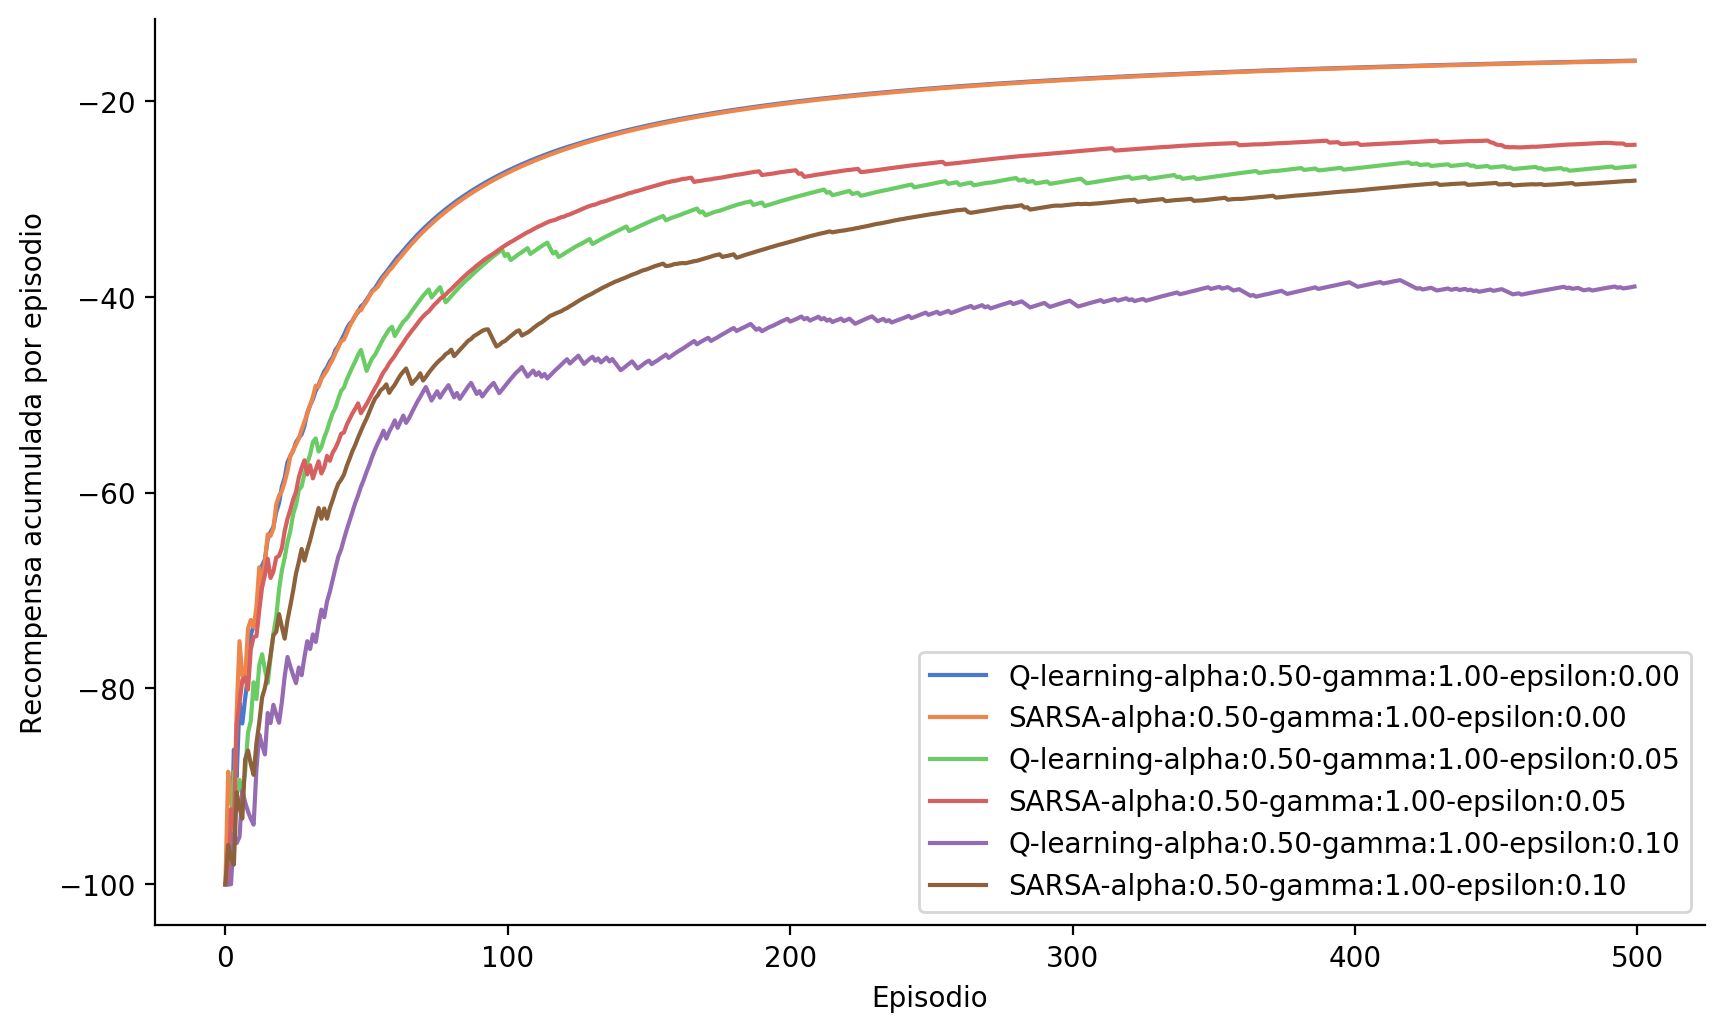

In [46]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(reward_ep_alpha)
sns.lineplot(data=df.rolling(500,min_periods=1).mean(),dashes=False, palette="muted")
sns.despine()

plt.ylabel("Recompensa acumulada por episodio")
plt.xlabel("Episodio")


Text(0.5, 0, 'Episodio')

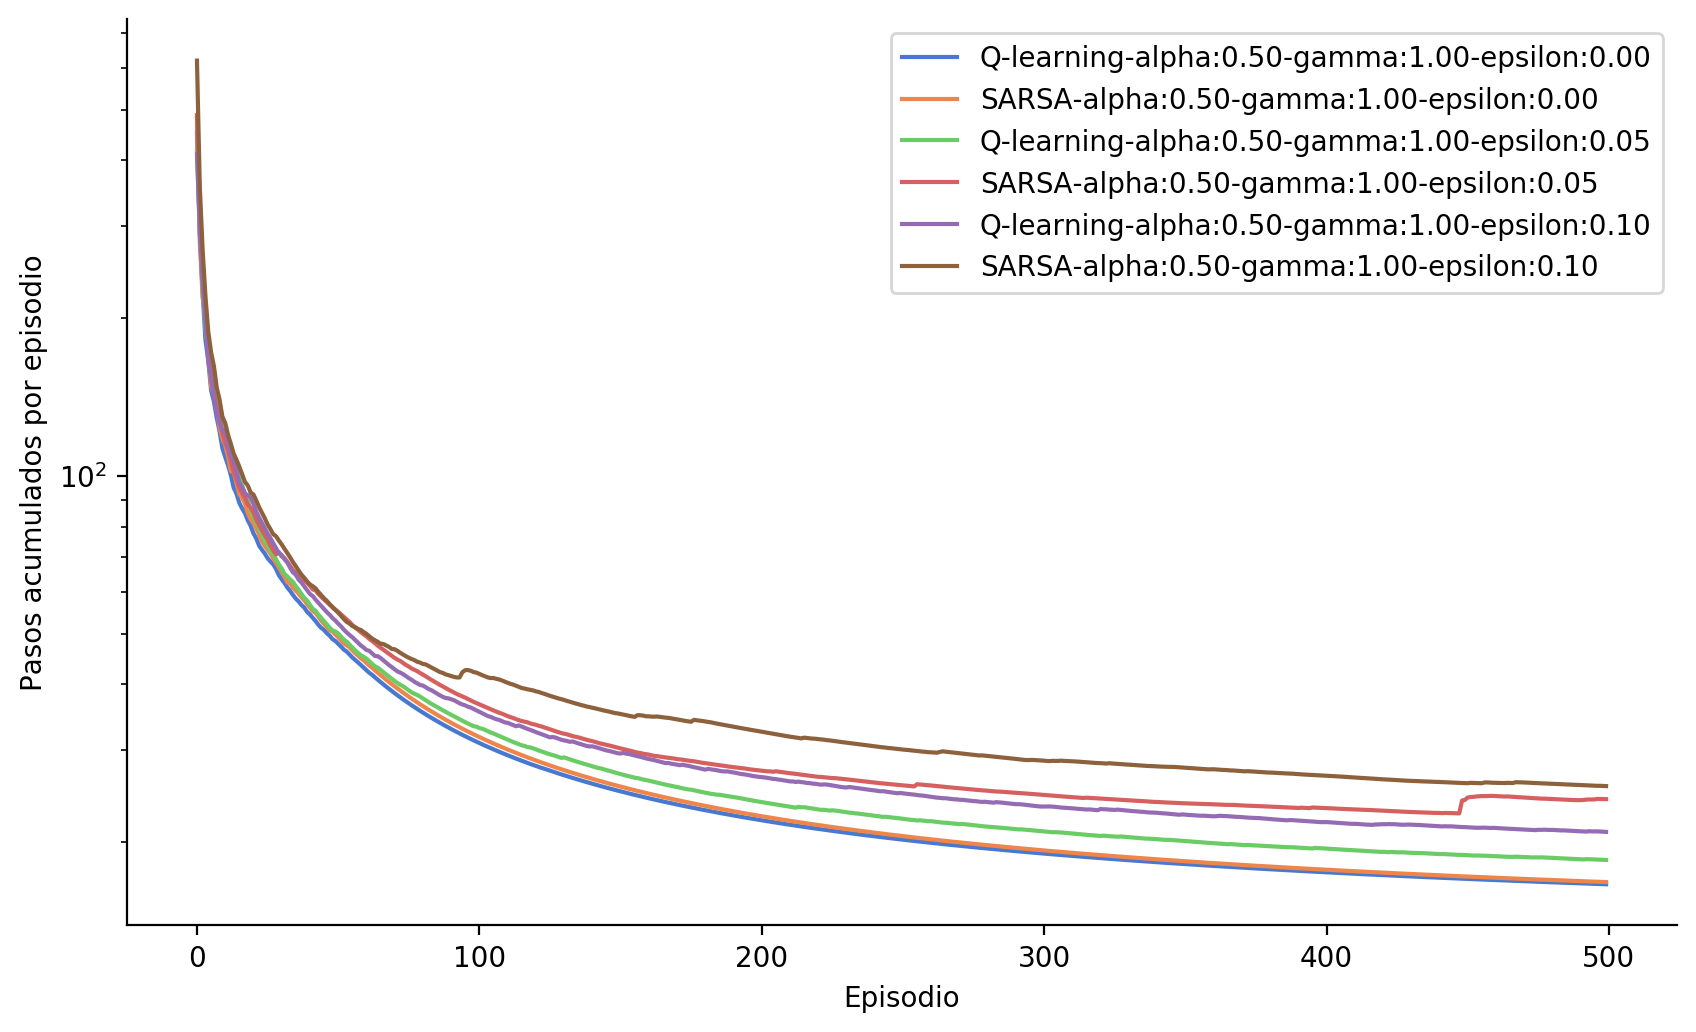

In [47]:
plt.figure(figsize=(10,6),dpi=200)
df = pd.DataFrame(timesteps_ep_alpha)
sns.lineplot(data=df.rolling(500,min_periods=1).mean(),dashes=False, palette="muted")
sns.despine()
plt.yscale("log")
plt.ylabel("Pasos acumulados por episodio")
plt.xlabel("Episodio")


In [48]:
q.keys()

dict_keys(['Q-learning-alpha:0.50-gamma:1.00-epsilon:0.00', 'SARSA-alpha:0.50-gamma:1.00-epsilon:0.00', 'Q-learning-alpha:0.50-gamma:1.00-epsilon:0.05', 'SARSA-alpha:0.50-gamma:1.00-epsilon:0.05', 'Q-learning-alpha:0.50-gamma:1.00-epsilon:0.10', 'SARSA-alpha:0.50-gamma:1.00-epsilon:0.10'])



-------------------------------------------------------------------

Q-learning-alpha:0.50-gamma:1.00-epsilon:0.00


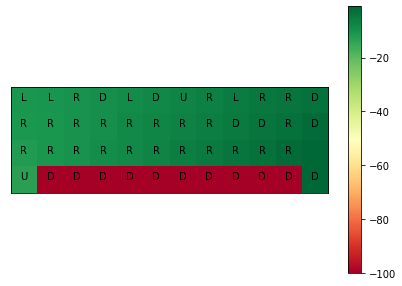


 Matriz de mejor acción-valor (en números): 

 [[ -11.          -10.62785434   -9.99859069   -9.24085543   -8.49678819
    -7.71514359   -7.           -6.18156064   -5.38985443   -4.61566532
    -3.78152895   -2.94775366]
 [ -11.28561462  -10.67529805   -9.92901639   -9.14634597   -8.30574473
    -7.45873582   -6.62224049   -5.80337819   -4.87382306   -3.94720121
    -2.98554563   -1.99984521]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


-------------------------------------------------------------------

SARSA-alpha:0.50-gamma:1.00-epsilon:0.00


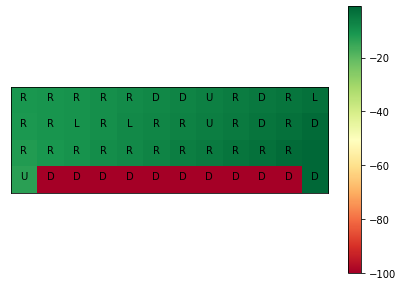


 Matriz de mejor acción-valor (en números): 

 [[ -10.95890766  -10.56830373   -9.90864798   -9.1725573    -8.54394561
    -7.64346689   -7.0069463    -6.11729813   -5.39324188   -4.53102136
    -3.75237465   -2.9375    ]
 [ -11.33053528  -10.63973943   -9.9408661    -9.21447711   -8.33194163
    -7.56509614   -6.65798628   -5.81132507   -4.90103876   -3.94153645
    -2.98636435   -1.99992921]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


-------------------------------------------------------------------

Q-learning-alpha:0.50-gamma:1.00-epsilon:0.05


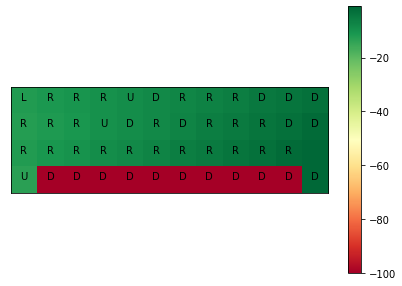


 Matriz de mejor acción-valor (en números): 

 [[ -12.          -11.3286869   -10.57860599   -9.86502089   -9.
    -8.25490402   -7.41119899   -6.62956022   -5.76857859   -4.85283935
    -3.93643045   -2.9964374 ]
 [ -12.46936671  -11.72993521  -10.82891986   -9.87752718   -8.97081455
    -7.98745983   -6.99336406   -5.99813712   -4.99928845   -3.99987454
    -2.9999942    -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


-------------------------------------------------------------------

SARSA-alpha:0.50-gamma:1.00-epsilon:0.05


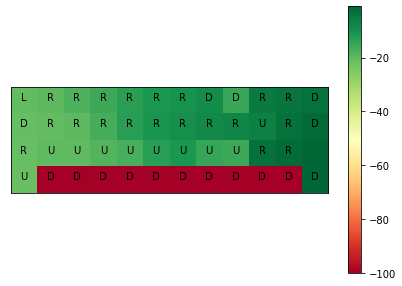


 Matriz de mejor acción-valor (en números): 

 [[ -20.36660457  -19.67345788  -17.75618504  -15.35372401  -13.07304123
   -11.3796795   -10.16324041   -9.11783399  -15.19245943   -5.2349475
    -4.09351611   -3.01564309]
 [ -21.03790509  -20.37406049  -19.57752785  -16.58939841  -12.60222306
   -10.48025972   -9.20114684   -8.16022611   -7.26567503   -6.32113502
    -3.00548194   -2.00001713]
 [ -21.39797755  -20.0407882   -20.18208055  -18.48048738  -17.18530384
   -12.8162121   -11.4070105   -14.83673727  -15.43400383   -3.00004325
    -2.00000238   -1.        ]
 [ -21.77660396 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


-------------------------------------------------------------------

Q-learning-alpha:0.50-gamma:1.00-epsilon:0.10


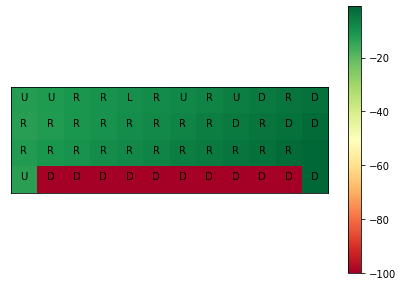


 Matriz de mejor acción-valor (en números): 

 [[ -12.46622757  -11.79222883  -11.00579778  -10.1585137    -9.37732512
    -8.63424071   -7.73235869   -6.83666768   -5.875        -4.93137253
    -3.9823668    -2.99888529]
 [ -12.97470896  -11.99720425  -10.99919886   -9.9997624    -8.99992845
    -7.99997537   -6.99999364   -5.99999679   -4.99999904   -3.99999986
    -2.99999999   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


-------------------------------------------------------------------

SARSA-alpha:0.50-gamma:1.00-epsilon:0.10


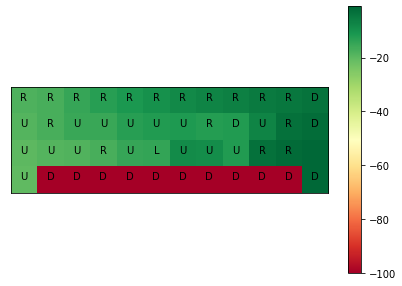


 Matriz de mejor acción-valor (en números): 

 [[ -17.73147374  -16.97886343  -14.79701507  -12.75746686  -11.30671007
    -9.69177321   -8.22509689   -7.05170633   -6.07951167   -5.1562693
    -4.39701994   -3.55966618]
 [ -18.57366444  -16.93621352  -15.01541534  -15.28899084  -12.83975499
   -11.85193319  -11.73601199  -12.44546151  -11.87502539   -6.8943611
    -3.02470637   -2.25639572]
 [ -19.57370702  -18.72766939  -18.1733768   -17.02835144  -14.56986652
   -14.17706143   -8.41337309   -9.11546041  -12.00256421   -3.22479912
    -2.06274272   -1.        ]
 [ -20.11537036 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [50]:
for key  in q.keys():
    print("")
    print("")
    print("-------------------------------------------------------------------")
    print("")
    print(key)
    draw_value_matrix(q[key])